In [13]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier as SklearnRF
from sklearn.metrics import confusion_matrix
import pandas as pd

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Linear Regression") \
    .getOrCreate()

In [16]:
file_path = "file:///C:/Users/nagia/Desktop/Realestate.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.show(3)

+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
| No|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|X6 longitude|Y house price of unit area|
+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
|  1|           2012.917|        32.0|                              84.87882|                             10|   24.98298|   121.54024|                      37.9|
|  2|           2012.917|        19.5|                              306.5947|                              9|   24.98034|   121.53951|                      42.2|
|  3|           2013.583|        13.3|                              561.9845|                              5|   24.98746|   121.54391|                      47.3|
+---+-------------------+---

In [22]:
import numpy as np
from pyspark.sql.functions import col
# Select the relevant columns and cast them to appropriate types
selected_cols = ['X2 house age', 'X3 distance to the nearest MRT station', 
                 'X4 number of convenience stores', 'Y house price of unit area']


In [23]:
# Create feature vector
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
data = assembler.transform(df).select("features", "Y house price of unit area")

In [24]:
# Rename the target feature column as "label"
data = data.withColumnRenamed("Y house price of unit area", "label")

In [25]:
# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [27]:
# Create a Linear Regression model
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="features", labelCol="label")

In [28]:
# Fit the model to the training data
lr_model = lr.fit(train_data)

In [31]:
# Generate predictions on the test data
predictions = lr_model.transform(test_data)
predictions.show(3)
df.show(3)

+--------------------+-----+-----------------+
|            features|label|       prediction|
+--------------------+-----+-----------------+
|[0.0,185.42959594...| 52.2|52.20000076293944|
|[0.0,208.39050292...| 45.7|45.70000076293946|
|[0.0,274.01440429...| 45.4| 45.4000015258789|
+--------------------+-----+-----------------+
only showing top 3 rows

+------------+--------------------------------------+-------------------------------+--------------------------+
|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|Y house price of unit area|
+------------+--------------------------------------+-------------------------------+--------------------------+
|        32.0|                              84.87882|                           10.0|                      37.9|
|        19.5|                              306.5947|                            9.0|                      42.2|
|        13.3|                              561.9845|                            

In [33]:
from pyspark.ml.evaluation import RegressionEvaluator
# Evaluate model performance
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

# R-squared (R2) Score
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print("R-squared (R2) Score:", r2)

# Adjusted R-squared Score
num_instances = predictions.count()
num_features = len(selected_columns)
adj_r2 = 1 - (1 - r2) * ((num_instances - 1) / (num_instances - num_features - 1))
print("Adjusted R-squared Score:", adj_r2)

# Mean Absolute Error (MAE)
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
print("Mean Absolute Error (MAE):", mae)

# Mean Squared Error (MSE)
mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
print("Mean Squared Error (MSE):", mse)

# Root Mean Squared Error (RMSE)
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
print("Root Mean Squared Error (RMSE):", rmse)

R-squared (R2) Score: 1.0
Adjusted R-squared Score: 1.0
Mean Absolute Error (MAE): 1.3262460809420514e-14
Mean Squared Error (MSE): 5.1627603615760885e-28
Root Mean Squared Error (RMSE): 2.272170847796461e-14


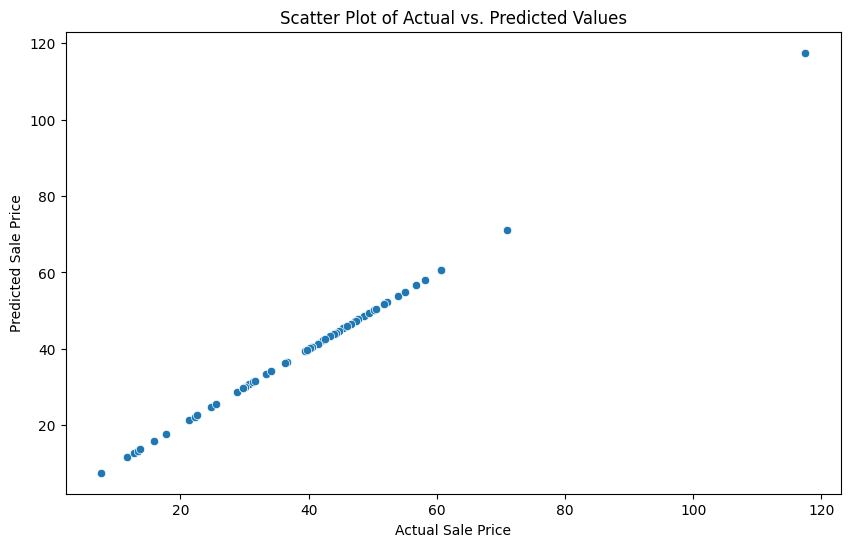

In [34]:
# Scatter Plot of Actual vs. Predicted Values
predictions_df = predictions.select("label", "prediction").toPandas()
plt.figure(figsize=(10, 6))
sns.scatterplot(x="label", y="prediction", data=predictions_df)
plt.title("Scatter Plot of Actual vs. Predicted Values")
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.show()

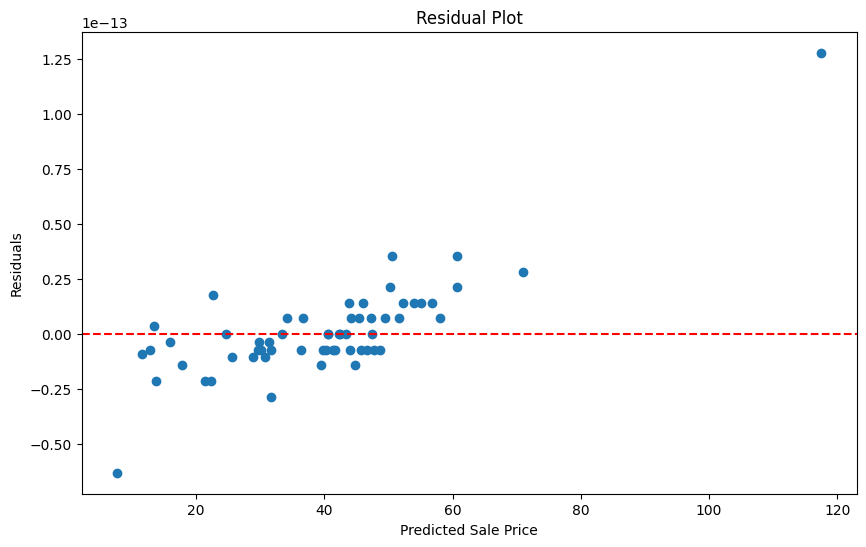

In [35]:
# Residual Plot
residuals = predictions_df["label"] - predictions_df["prediction"]
plt.figure(figsize=(10, 6))
plt.scatter(predictions_df["prediction"], residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted Sale Price")
plt.ylabel("Residuals")
plt.show()

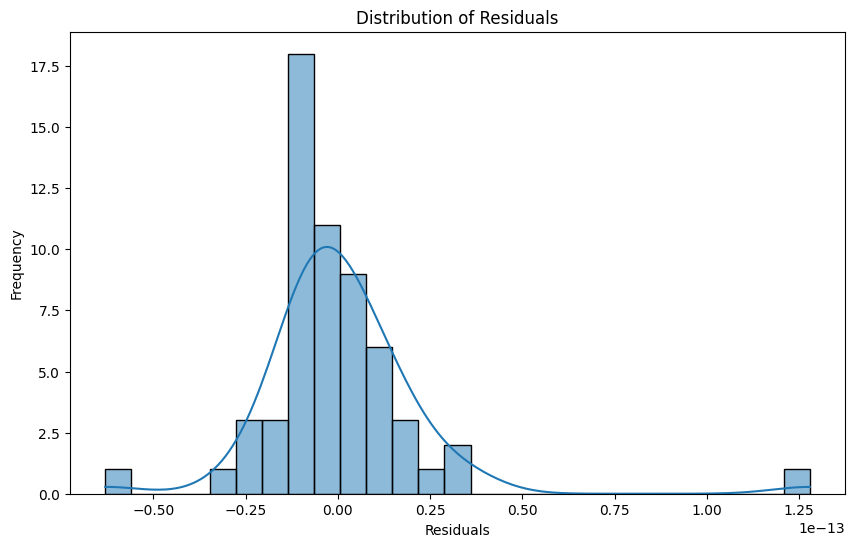

In [36]:
# Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

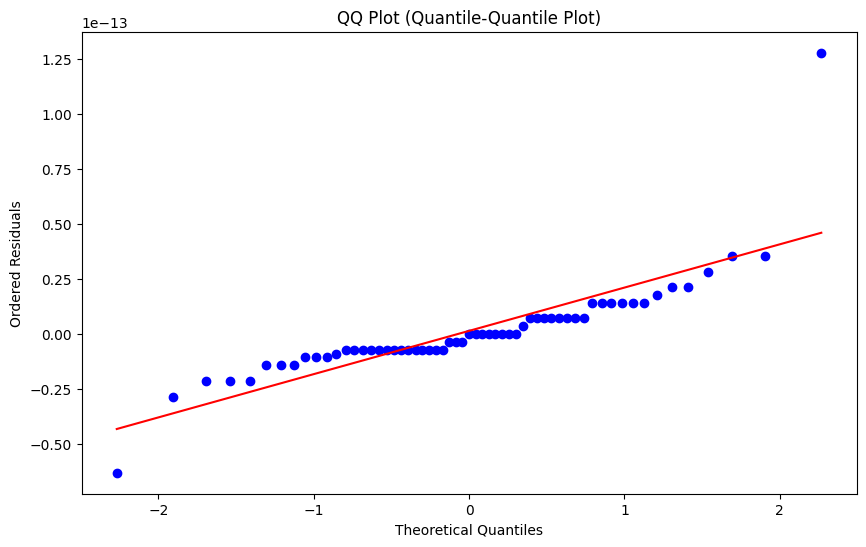

In [38]:
# QQ Plot (Quantile-Quantile Plot)
from scipy.stats import probplot
plt.figure(figsize=(10, 6))
probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot (Quantile-Quantile Plot)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Ordered Residuals")
plt.show()

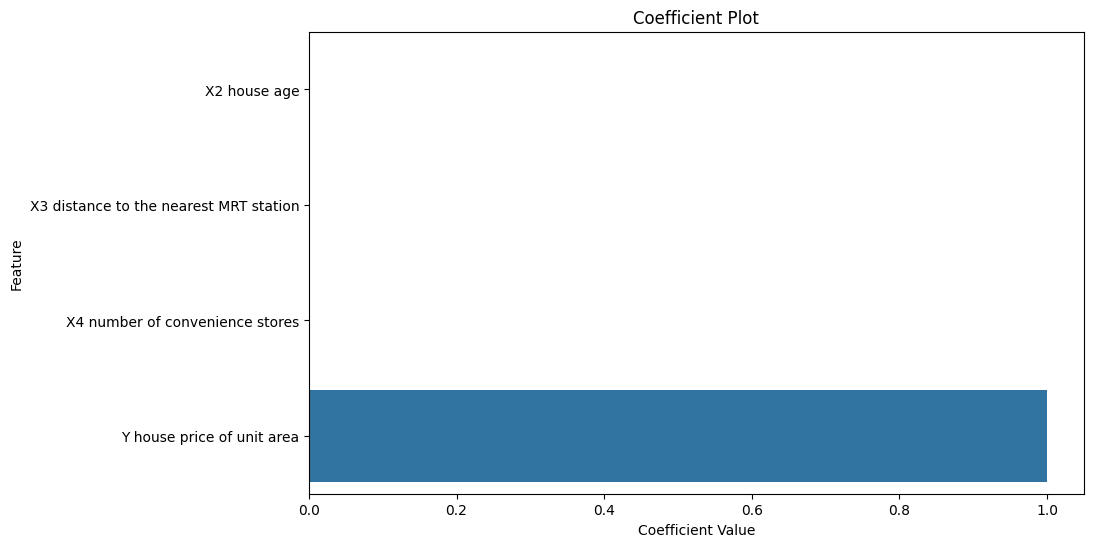

In [39]:
# Coefficient Plot
coefficients = lr_model.coefficients
coefficients_df = pd.DataFrame({"Feature": selected_columns, "Coefficient": coefficients})
plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=coefficients_df)
plt.title("Coefficient Plot")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

In [43]:
predictions.show(3)

+--------------------+-----+-----------------+
|            features|label|       prediction|
+--------------------+-----+-----------------+
|[0.0,185.42959594...| 52.2|52.20000076293944|
|[0.0,208.39050292...| 45.7|45.70000076293946|
|[0.0,274.01440429...| 45.4| 45.4000015258789|
+--------------------+-----+-----------------+
only showing top 3 rows

